# Distances

Pertpy implements distance metrics between groups of
single cells in the module `pertpy.tl.Distance`. This notebook shows some of the available 
distances and use cases in data analysis of perturbation data.

There are many different ways to measure the distance between two groups of
cells, sometimes referred to as 'point cloud distance metrics'. The simplest one is the Euclidean distance between the
average expression of the two groups (We call this "pseudobulk" distance). 
However, this distance is not very informative, as it does not take into
account the variability of the expression of the individual cells or the shape of the underlying distribution. 

Other implemented distance functions have different ways of incorporating the distribution of single cells
into the distance calculation. 


Currently available distances are:
- E-distance
- Pseudobulk distance
- Maximum mean discrepancy
- Wasserstein distance
- Mean pairwise distance

In [10]:
import scanpy as sc
import numpy as np
import pertpy as pt
import matplotlib.pyplot as plt
from seaborn import clustermap

# Loading the Example Dataset

Here we use an example dataset, which is a subsetted and already preprocessed
version of data from the original Perturb-seq paper (Dixit et al., 2016). The full dataset can be accessed using 
`pt.dt.dixit_2016()`.

__Note__ that most distances are computed in PCA space to avoid the curse of dimensionality or to speed up computation. When using your own dataset __run__ `scanpy.pp.pca` __first__, prior to using the distance methods. 
If you would prefer to compute distances in a different space, 
specify an alternative `obsm_key` argument when calling the distance function.


In [2]:
adata = pt.dt.distance_example_data()
obs_key = 'perturbation'  # defines groups to test

In [3]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)

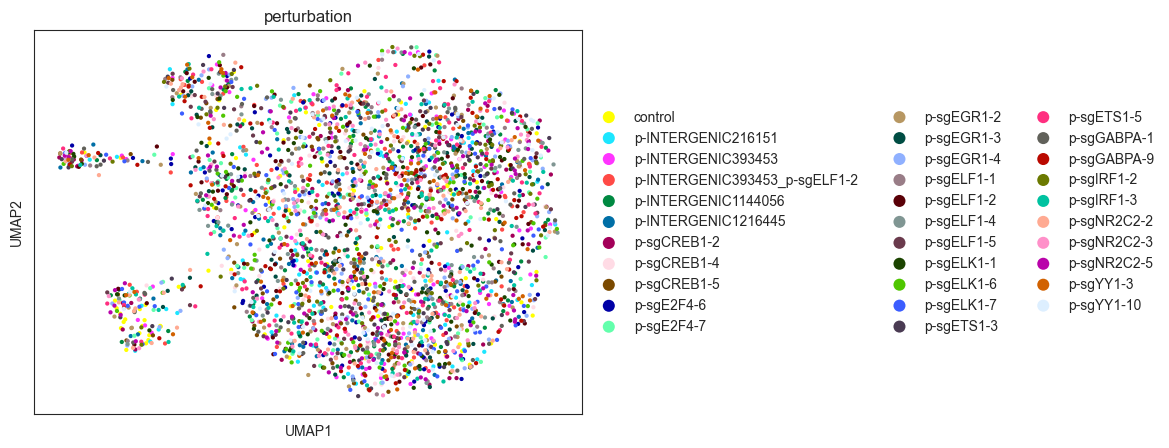

In [4]:
sc.pl.scatter(adata, basis='umap', color=obs_key, show=True)

Looking at the UMAP, perturbations seem well-mixed, suggesting that distances between them
will be small. These distance measures formalize that intuition in a higher-dimensional space.

# Available Distances

## E-distance

The E-distance (short for energy distance) is defined as twice the average distance between
the two groups of cells minus each the average distance between the cells within
each group. By this, the E-distance intuituively relates the distance between
to the distance within groups. For more information on E-distance for single cell analysis,
see [Peidli et al., (2023)](https://doi.org/10.1101/2022.08.20.504663).

In [21]:
distance = pt.tl.Distance('edistance', 'X_pca')
df = distance.pairwise(adata, groupby=obs_key, verbose=True)

Output()

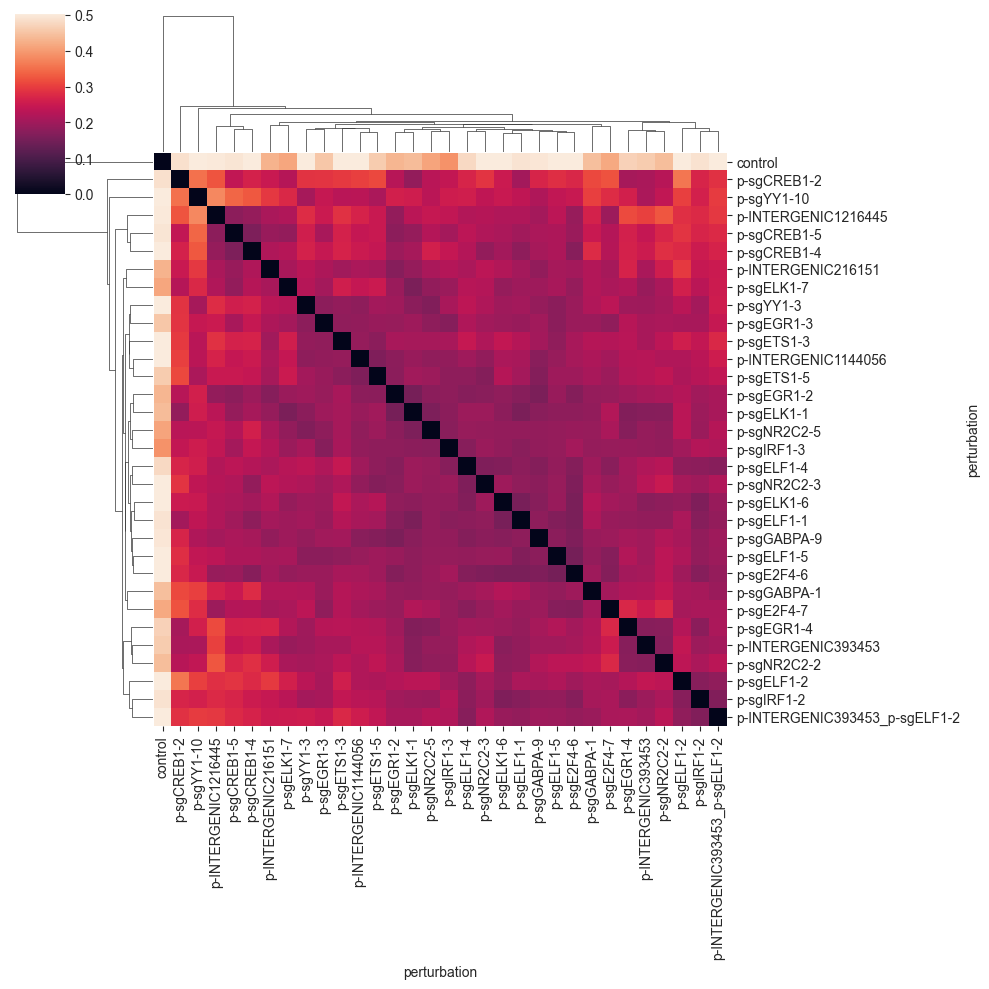

In [22]:
clustermap(df, robust=True, figsize=(10,10))
plt.show()

You can see that the E-distance is very small for the perturbations that are well-mixed,
and increases for perturbations that are more separated. For example, the last three perturbations
are quite similar and form a small cluster. You will see that the E-distance between guides
targeting the same or similar genes is smaller on average.

Importantly, the control cells are quite far away from the perturbed cells; a good sign that the perturbations are working as expected.
Also, the diagonal of the distance matrix is zero, as the distance of one group to itself should be zero for a proper distance metric.

## PseudobulkDistance

The pseudobulk distance is the Euclidean distance between the average expression
of the two groups. This average approximates bulk RNA-seq measurement of each group.
While intuitive, it does not take into account
the variability of the expression of the individual cells.

Nevertheless, pseudobulk distance is widely used and can be useful to compare with 
other distances.

In [23]:
distance = pt.tl.Distance('pseudobulk', 'X_pca')
df = distance.pairwise(adata, groupby=obs_key, verbose=True)

Output()

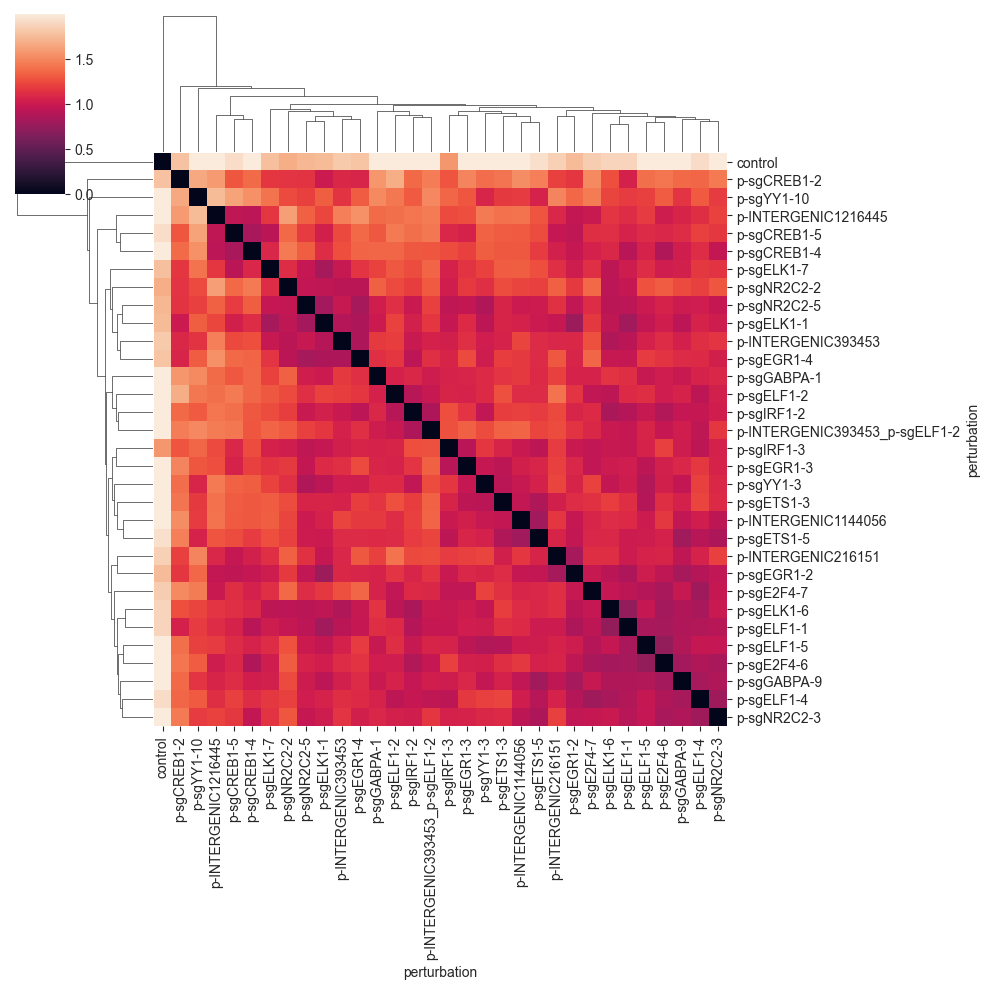

In [24]:
clustermap(df, robust=True, figsize=(10,10))
plt.show()

The pairwise distance matrix shows bigger clusters of sometimes similar perturbations.
While there is some similarity to the E-distance heatmap, you will see that different distances tend to represent the data in different ways.

## Mean Pairwise Distance

The mean pairwise distance is the mean of the pairwise distances between all
cells in the two groups.

In [5]:
distance = pt.tl.Distance('mean_pairwise', 'X_pca')
df = distance.pairwise(adata, groupby=obs_key, verbose=True)

Output()

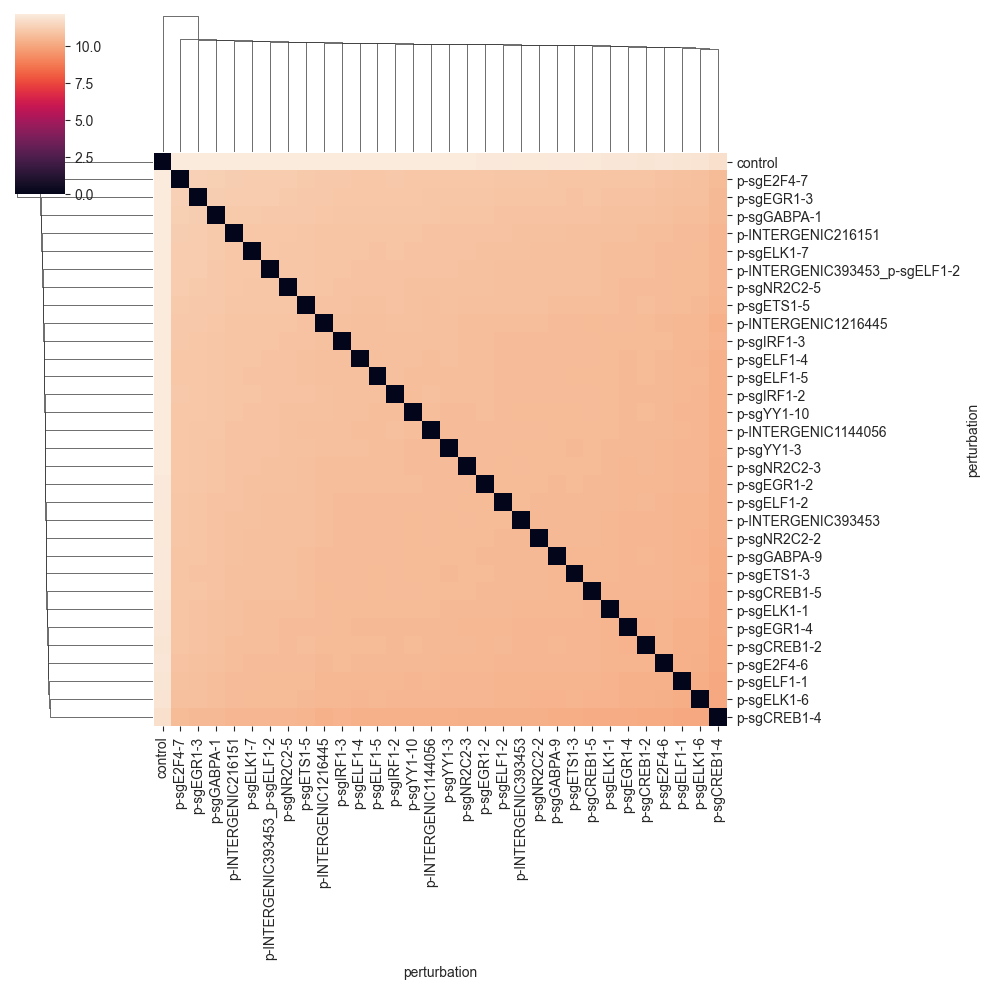

In [6]:
clustermap(df, robust=True, figsize=(10,10))
plt.show()

Since the distance values are quite far away from 0, we do not see that much.
We can get a better picture of the distances by changing the color range to start not from zero, but from the minimum non-zero distance value.:

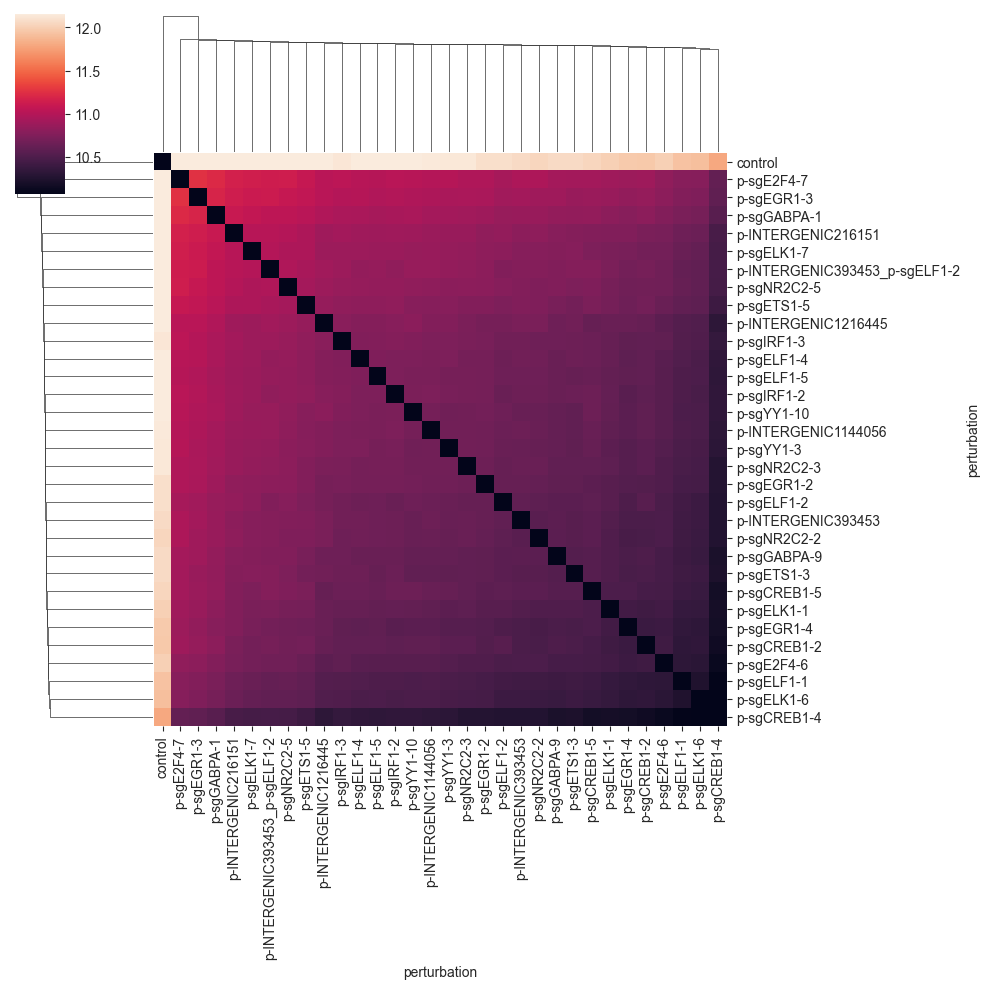

In [14]:
values = np.ravel(df.values)
nonzero = values[values != 0]
vmin = np.min(nonzero)
clustermap(df, robust=True, figsize=(10,10), vmin=vmin)
plt.show()

While we can see that the control cells are quite far away from the perturbed cells, the distance between the perturbations is not very informative.

## Wasserstein Distance

The Wasserstein distance is a distance between two probability distributions.
It can be computed by solving an optimization problem called the
optimal transport problem. 

Intuitively, the Wasserstein distance measures the minimal amount of "work"
needed to transform one distribution into the other. This is done by finding an 
optimal transport plan, which describes how to move mass (cells) from one group 
to another. The optimal transport plan is then the one that minimizes the
overall sum of distances that mass (cells) have to be moved.

The optimal cost of this solution&mdash;the amount of "work" required&mdash;is then the
Wasserstein distance. In this implementation, we solve the regularized optimal 
transport problem using the Sinkhorn algorithm (Cuturi, 2013).

In [15]:
distance = pt.tl.Distance('wasserstein', 'X_pca')
df = distance.pairwise(adata, groupby=obs_key, verbose=True)

Output()

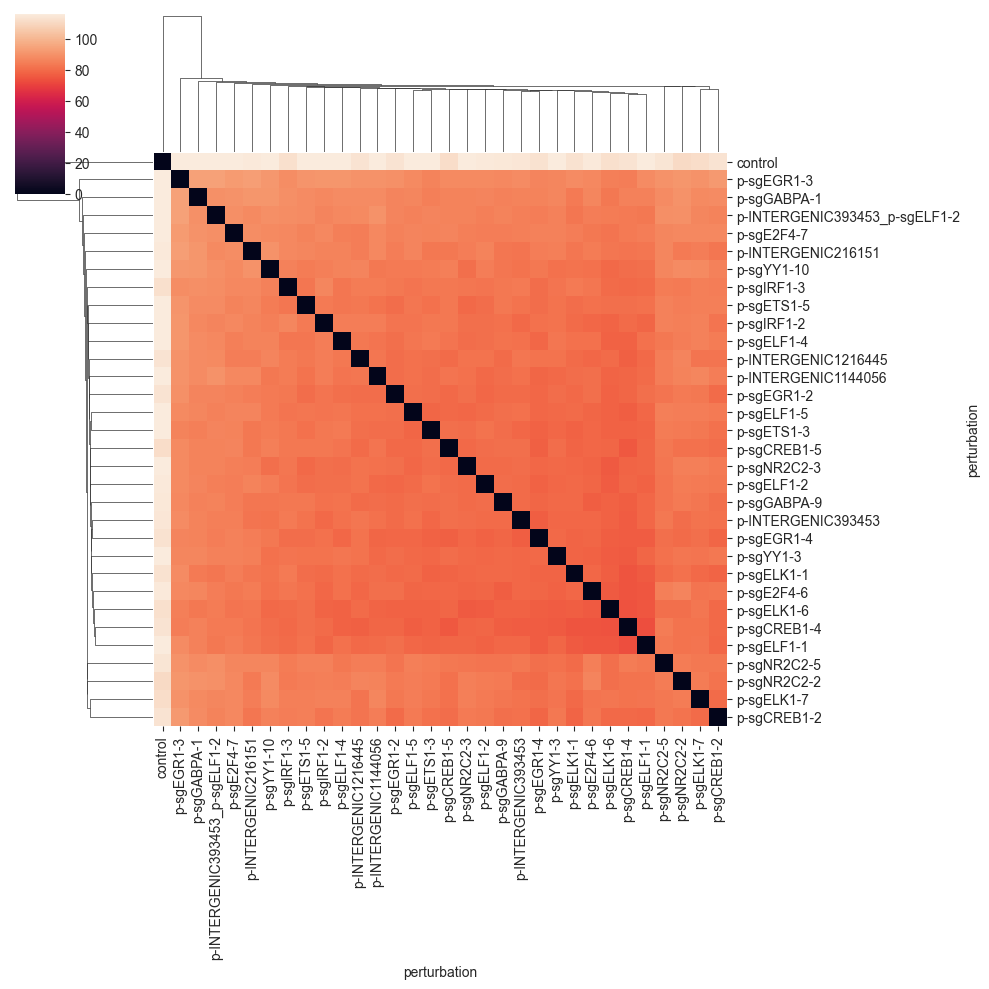

In [16]:
clustermap(df, robust=True, figsize=(10,10))
plt.show()

As was the case for the previous distance, the values are quite far away from 0, so we do not see that much.
We can get a better picture of the distances by changing the color range:

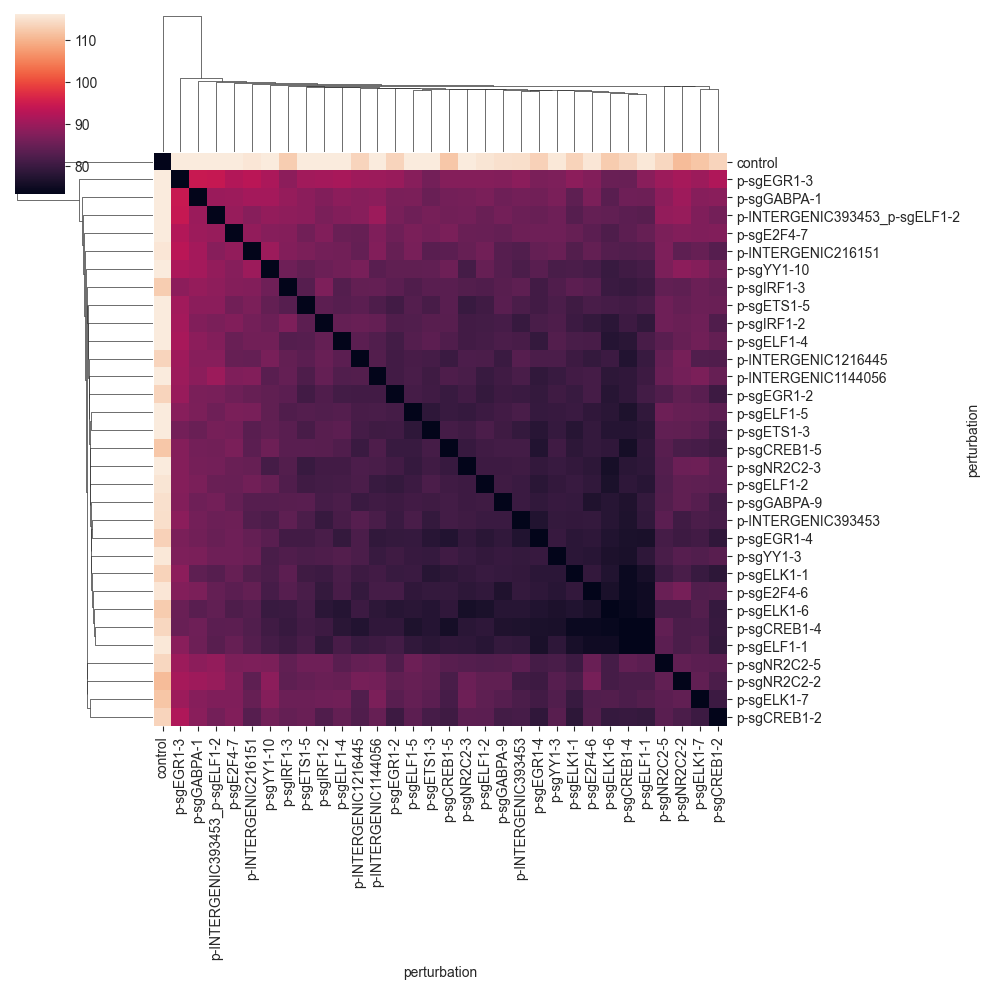

In [17]:
values = np.ravel(df.values)
nonzero = values[values != 0]
vmin = np.min(nonzero)
clustermap(df, robust=True, figsize=(10,10), vmin=vmin)
plt.show()

We can now more clearly see that there is a big cluster of perturbations that are comparably similar to each other.
Also we can see that the last four perturbations in the matrix do not fit into this cluster.

## MMD

The maximum mean discrepancy (MMD) is a statistical distance. It is defined as the distance between embeddings of probability distributions in a reproducing kernel hilbert space.
For more information on MMD for single cell biology see [Lotfollahi et al. (2019)](https://arxiv.org/abs/1910.01791). 
The specific implementation provided here is a simplified version of [this code](https://github.com/jindongwang/transferlearning/blob/master/code/distance/mmd_numpy_sklearn.py).

In [19]:
distance = pt.tl.Distance('mmd', 'X_pca')
df = distance.pairwise(adata, groupby=obs_key, verbose=True)

Output()

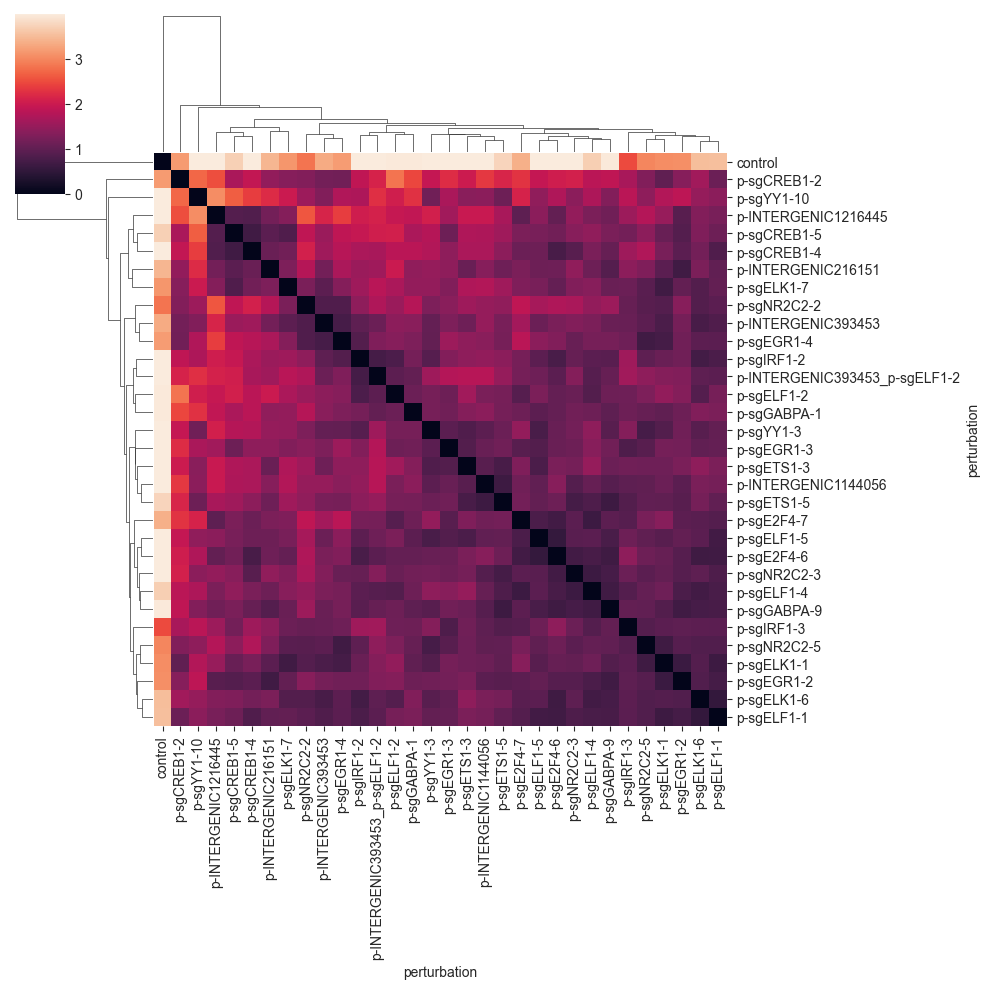

In [20]:
clustermap(df, robust=True, figsize=(10,10))
plt.show()

The MMD seems to group the perturbations in a similar way as the E-distance, but at a different scale.
We can see the formation of a few cluster, which tend to have perturbations targeting the same or similar target.

# Use Cases

Let's first cluster the data to get more clearly visible groups of cells.

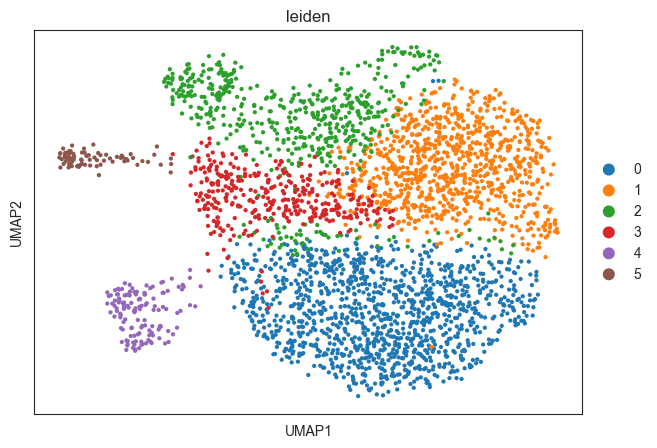

In [174]:
sc.tl.leiden(adata, resolution=0.5)
sc.pl.scatter(adata, basis='umap', color='leiden')

## Cluster Hierarchies

In [61]:
distance = pt.tl.Distance('edistance', 'X_pca')
df = distance.pairwise(adata, groupby='leiden', verbose=True)

Output()

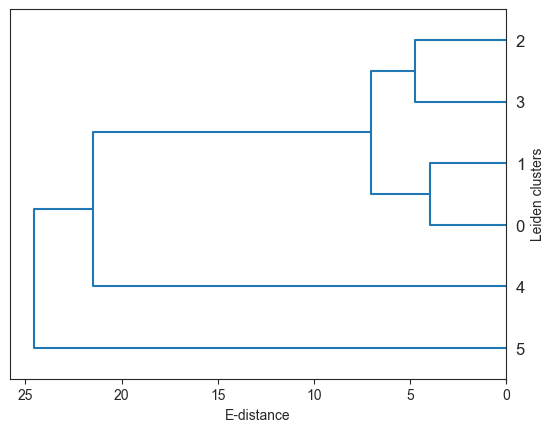

In [63]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(df, method='ward')
hierarchy = dendrogram(Z, labels=df.index, orientation='left', color_threshold=0)
plt.xlabel('E-distance')
plt.ylabel('Leiden clusters')
plt.gca().yaxis.set_label_position("right")
plt.show()

As demonstrated here, distances between single-cell groups can be used to build cluster hierarchies, which can be used to visualize the data in a more condensed way. For example, you can generate such a hierarchy for you cell type annotation.

## Specific Cluster Similarities

Let's say we want to find to find out if cluster 4 is more similar to cluster 0 or to cluster 3. 
We can do this by computing the distance between cluster 4 and the other two as follows:

In [66]:
distance = pt.tl.Distance('edistance', 'X_pca')
df = distance.pairwise(adata[adata.obs.leiden.isin(['0', '3', '4'])], groupby='leiden', verbose=False)

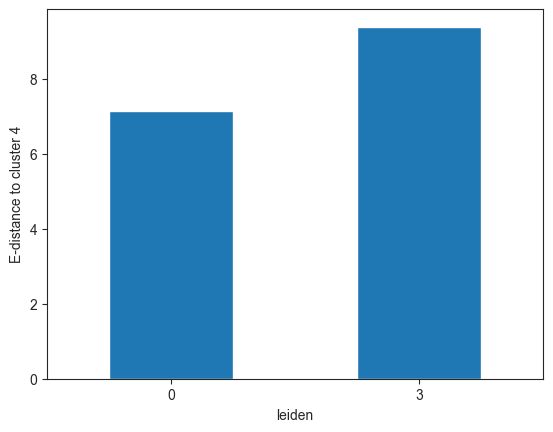

In [74]:
df['4'][['0', '3']].plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('E-distance to cluster 4')
plt.show()

We can clearly see that cluster 4 is more similar to cluster 0 than to cluster 3, as it has a lower distance to the former.

## Statistical Testing

See the [statistical testing notebook](statistical_testing.ipynb) for an example.